In [1]:
import os
import pandas as pd
import random
from openai import AzureOpenAI
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import matplotlib.pyplot as plt

# Load environment variables from .env file
load_dotenv()

    
client = AzureOpenAI(
    api_key=os.getenv('AZURE_OPENAI_API_KEY'),  
    api_version="2023-12-01-preview",
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT')
)




# # Initialize the OpenAI model
# openai_api_key = os.getenv('OPENAI_API_KEY')
# openai_model = ChatOpenAI(
#     model="gpt-3.5-turbo",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
#     api_key=openai_api_key)

# llm = client

In [2]:
#Load csv into df 
df = pd.read_csv('statementData.csv', encoding='latin1')

#Translated column names 
df.columns = [
    'Account Number', 'Currency', 'BIC', 'Sequence Number', 'Date', 'Interest Date',
    'Amount', 'Balance After Transaction', 'Counterparty Account Number', 'Counterparty Name',
    'Ultimate Party Name', 'Initiating Party Name', 'Counterparty BIC', 'Code', 'Batch ID',
    'Transaction Reference', 'Mandate Reference', 'Creditor ID', 'Payment Reference', 'Description-1',
    'Description-2', 'Description-3', 'Return Reason', 'Original Amount', 'Original Currency', 'Exchange Rate'
]

#Drop unecessary columns 
columns_to_drop = [
    'Account Number', 'Currency', 'BIC', 'Sequence Number', 'Interest Date', 'Balance After Transaction', 'Counterparty Account Number', 'Ultimate Party Name', 'Initiating Party Name', 'Counterparty BIC', 'Code', 'Batch ID',
    'Transaction Reference', 'Mandate Reference', 'Creditor ID', 'Payment Reference', 'Description-1','Description-2', 'Description-3', 'Return Reason', 'Original Amount', 'Original Currency', 'Exchange Rate'
]

df.drop(columns=columns_to_drop, inplace=True)

In [3]:
# Convert Amount column to numerical values
df['Amount'] = df['Amount'].str.replace(',', '.').astype(float)
df['Amount'] = df['Amount'].abs()
categories = ['Salary', 'Groceries', 'Mortgage', 'Eating out', 'Lesiure','Other']
# Function to categorize transactions
def random_category(row):
    return random.choice(categories)

# Add Category column
df['Category'] = df.apply(random_category, axis=1)


# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')


In [4]:
df['Month'] = df['Date'].dt.to_period('M')
average_per_category_month = df.groupby(['Category'])['Amount'].mean().reset_index(name='Average Amount')

In [5]:
display(average_per_category_month)

,Category,Average Amount
0,Eating out,418.303256
1,Groceries,559.521915
2,Lesiure,256.918485
3,Mortgage,415.927692
4,Other,608.417179
5,Salary,370.601818


In [6]:
highest_purchase_per_month = df.loc[df.groupby('Month')['Amount'].idxmax()]

In [7]:
display(highest_purchase_per_month)

,Date,Amount,Counterparty Name,Category,Month
22,2024-01-25,5156.88,Zicht Consultants B.V.,Salary,2024-01
47,2024-02-23,3369.91,Rabobank,Other,2024-02
75,2024-03-22,3371.38,Rabobank,Groceries,2024-03
97,2024-04-24,3562.48,Rabobank,Groceries,2024-04
176,2024-05-24,5310.01,Rabobank,Mortgage,2024-05
225,2024-06-03,1557.59,Coöperatieve Rabobank U.,Groceries,2024-06


In [8]:
display(df)

,Date,Amount,Counterparty Name,Category,Month
0,2024-01-01,159.00,R C van der Krift,Salary,2024-01
1,2024-01-01,28.99,A. Kfoury eo R.C. van der Krift,Salary,2024-01
2,2024-01-02,247.89,A. Kfoury eo R.C. van der Krift,Groceries,2024-01
3,2024-01-02,247.89,Vereniging van Eigenaars Amsterdamsestraatweg ...,Salary,2024-01
4,2024-01-02,354.00,A. Kfoury eo R.C. van der Krift,Other,2024-01
...,...,...,...,...,...
253,2024-06-18,6.77,ALBERT HEIJN 2202,Lesiure,2024-06
254,2024-06-18,11.45,RABOBANK 3578,Salary,2024-06
255,2024-06-18,3.98,Albert Heijn Konincks,Eating out,2024-06
256,2024-06-19,8.64,Interpolis,Eating out,2024-06


In [9]:
# trend_df = df.groupby([df['Date'].dt.to_period('M'), 'Category'])['Amount'].sum().unstack().fillna(0)

In [10]:
# display(trend_df)

In [11]:
salary_per_month = df[df['Category'] == 'Salary'].groupby(df['Date'].dt.to_period('M'))['Amount'].sum()

In [12]:
expenses_per_month = df[df['Category'] != 'Salary'].groupby(df['Date'].dt.to_period('M'))['Amount'].sum()

In [13]:
salary_saving_df = pd.DataFrame({
    'Total Salary': salary_per_month,
    'Total Expenses': expenses_per_month
}).fillna(0)

salary_saving_df['Salary Saving'] = salary_saving_df['Total Salary'] - salary_saving_df['Total Expenses']

In [14]:
display(salary_saving_df)

,Total Salary,Total Expenses,Salary Saving
Date,,,
2024-01,8062.91,14151.28,-6088.37
2024-02,2816.15,13765.09,-10948.94
2024-03,469.13,14529.39,-14060.26
2024-04,25.04,15197.75,-15172.71
2024-05,4778.49,38329.55,-33551.06
2024-06,154.76,2146.33,-1991.57


In [15]:
category_spending_per_month = df.pivot_table(index='Category', columns='Month', values='Amount', aggfunc='sum').fillna(0)
category_spending_per_month = category_spending_per_month.merge(average_per_category_month, on='Category', how='left')
category_spending_per_month.rename(columns={'Average Amount': 'Category Average'}, inplace=True)

In [16]:
display(category_spending_per_month)

,Category,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,Category Average
0,Eating out,148.00,4352.84,4637.58,1140.19,7491.84,216.59,418.303256
1,Groceries,2550.84,1623.54,6857.65,8151.34,5417.19,1696.97,559.521915
2,Lesiure,2809.73,0.00,965.00,1820.00,2769.26,114.32,256.918485
3,Mortgage,4750.71,3353.20,650.06,972.52,11875.71,26.04,415.927692
4,Other,3892.00,4435.51,1419.10,3113.70,10775.55,92.41,608.417179
5,Salary,8062.91,2816.15,469.13,25.04,4778.49,154.76,370.601818


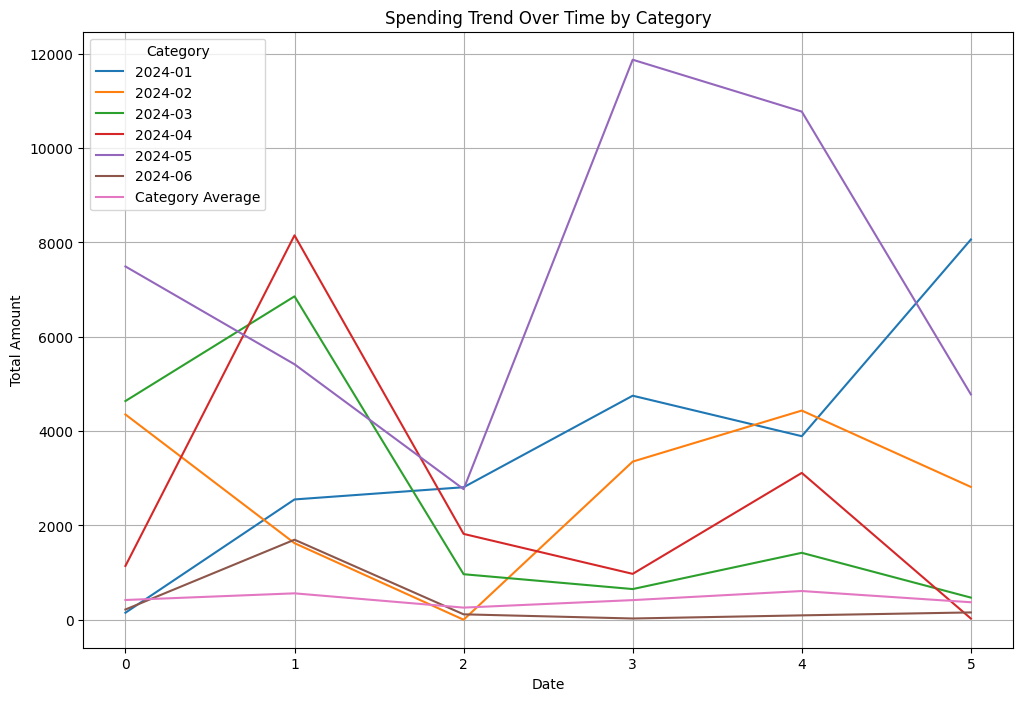

In [17]:
# Plot the trend over time for each category
category_spending_per_month.plot(kind='line', figsize=(12, 8))
plt.title('Spending Trend Over Time by Category')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend(title='Category')
plt.grid(True)
plt.show()

In [18]:
ragDict = {
    'Monthly Category Spend' : category_spending_per_month,
    'Highest Purchase Per Month': highest_purchase_per_month,
    'Savings Over Months' : salary_saving_df
}

In [19]:
conversation=[{"role": "system", 
               "content": f'''
    You are a Financial advisor. Please help the user make good financial decisions.
    If you are unsure what the user is asking for exactly, please ask them to clarify. If you get given a context, which is a dictionary of dataframes,
    You need to analyze each dataframe and reflect your thinking process, normally you should follow 3 steps
     Step 1: Analyze the monthly category spend dataframe. In this dataframe you will find the average spending per category and how much the user has spent per month. You should compare the monthly spending with the average.
     If the spending is around 10% higher than average then you should point it out and give your advice.
     Step 2: Analyze the highest purchase per month dataframe. In this dataframe you will find the highest purchase the user did per month. Make them aware of it. 
     Step 3: Analyze the Savings Over Months dataframe. In this dataframe you will see how much money the user was able to save for the each month. They should be able to save at least 10% of their salary. If they do not meet this criteria. Give them advice on how achieve that goal
    '''}]


user_input = f'''Q:
                Context: {ragDict}'''    
conversation.append({"role": "user", "content": user_input})

response = client.chat.completions.create(
    model="financialAdvisor-4o",
    messages=conversation
)

conversation.append({"role": "assistant", "content": response.choices[0].message.content})
print("\n" + response.choices[0].message.content + "\n")


Let's go through the analysis step by step, looking at the provided dataframes:

### Step 1: Analyze the Monthly Category Spend

From the 'Monthly Category Spend' dataframe, we can see how your spending in various categories compares to the average spending per category. Here are some key observations:

- **Eating out**:
  - January: $148.00
  - February: $4352.84
  - March: $4637.58
  - April: $1140.19
  - May: $7491.84
  - June: $216.59
  - **Category Average**: $418.30
  - **Observation**: Your spending on eating out is drastically higher than the average in February, March, and May. You may want to review these expenses and consider reducing them.

- **Groceries**:
  - January: $2550.84
  - February: $1623.54
  - March: $6857.65
  - April: $8151.34
  - May: $5417.19
  - June: $1696.97
  - **Category Average**: $559.52
  - **Observation**: Your grocery expenses are significantly higher than the average, especially from March to May. Consider planning meals and shopping for deals to

In [20]:
# messages = [
#     ("system", f'''
#     You are a Financial advisor. Please help the user make good financial decisions.
#     If you are unsure what the user is asking for exactly, please ask them to clarify. If you get given a context, which is a dictionary of dataframes,
#     You need to analyze each dataframe and reflect your thinking process, normally you should follow 3 steps
#      Step 1: Analyze the monthly category spend dataframe. In this dataframe you will find the average spending per category and how much the user has spent per month. You should compare the monthly spending with the average.
#      If the spending is around 10% higher than average then you should point it out and give your advice.
#      Step 2: Analyze the highest purchase per month dataframe. In this dataframe you will find the highest purchase the user did per month. Make them aware of it. 
#      Step 3: Analyze the Savings Over Months dataframe. In this dataframe you will see how much money the user was able to save for the each month. They should be able to save at least 10% of their salary. If they do not meet this criteria. Give them advice on how achieve that goal
#     '''),
#     (f'''Can you give me some advice on how I can save money in the future?
#      Context: 
#      {ragDict}
#      '''),
# ]
# llm.invoke(messages).content